# Instalando bibliotecas

In [ ]:
""" Installing libraries """
%pip install pandas==2.3.2 matplotlib==3.10.6 seaborn==0.13.2 scikit-learn==1.7.1 numpy==2.2.6 pyarrow==21.0.0
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu129

# Importando bibliotecas (externas e próprias)

In [42]:
""" Importing libraries """

import sys
import os

# Add the parent directory to sys.path so 'Modules' can be imported
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Our modules
from Modules.loading.read_parquet import read_parquet_file 
from Modules.preprocessing.onehot import one_hot_encode_parquet
from Modules.models.make_dataset import SingleSeriesDataset, MultiSeriesDataset
from Modules.models.NBeats import NBeatsBlock, NBeats
from Modules.models.WMAPELoss import WMAPELoss
from Modules.models.training import train_model
from Modules.models.test import soft_test
from Modules.models.test import hard_test
from Modules.models.forecast import forecast_blind
from Modules.loading.plug_n_play import get_clean_data

In [43]:
xd = get_clean_data(verbose=True)

16:09:739 FILE_PATHS
00:00:000 loaded_data
00:01:853 numerical_table
00:00:549 outlierless
00:00:683 pivoted_df
00:12:902 rescaled_df
00:02:898 copying
00:00:980 returning


# Definição dos hiper-parâmetros

In [44]:
""" Defining hyper-parameters """
# Neural Network Global Parameters
input_size = 30  # Number of past days to use as input
output_size = 7  # Number of future days to predict
batch_size = 28  # Batch size for training

n_layers = 4  # Number of layers in the N-BEATS model
hidden_size = 128  # Number of hidden units in each layer

# Training parameters
learning_rate = 1e-3 # Learning rate for the optimizer
epochs = 500  # Number of training epochs (iterations over the entire dataset)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
blind_horizon = 4  # Number of days to exclude from the end of the training set for hard test
split = 1 # Proportion of data to use for training (1.0 for validation)

# Importação do Dataset

É interessante dividir o treino em batches (mini-conjuntos de treino). Cada batch possui o tamanho de input size, seguindo a ordem cronológica de vendas dentro daquela janela de dias. No entanto, durante o treinamento é **ESSENCIAL** que a escolha do próximo batch seja aleatória.

Ex.: Inicia o treino por 21-27 jul e prevê 28, depois pula para 02-08 fev para prever 03. Esse processo deve ser repetido até todos os dados serem treinados, finalizando **01 epoch**.

O número de **epochs** diz o número total de iterações do modelo com relação ao dataset inteiro.

Sobre a composição da janela de input dentro de um batch, existem duas abordagens:

1) Treinar em cada janela todas as séries (pense que cada par produto-loja x tempo representa uma série temporal dentro daquele período). Esse modelo é bem mais complexo pois o output deve ter o mesmo tamanho de produto-loja.
2) Treinar vários modelos separados (considerando uma série temporal para cada modelo). Esse método é ineficiente pois o modelo nunca irá aprender os padrões entre as séries.
3) Treinar o modelo com um par produto-loja por vez. Ou seja:
   - O modelo realiza epochs = N iterações de treino ao longo de todo dataset
     - Em cada epoch, passa por todas as M batches
       - Em cada batch (que possui uma janela de tamanho input_size), atualiza os parâmetros para cada série temporal ($x_l,y_l$). Totalizando L atualizações, com L sendo o número de pares produto-loja.

Ressalta-se que cada conjunto ($x_l,y_l$) representa:
- $x_l$: série temporal do l-ésimo par produto-loja, sendo um vetor de tamanho input_size x (features + 1)
- $y_l$: Previsão de vendas do l-ésimo par produto-loja para os próximos $output_size$ dias


In [5]:
""" Setting up the constants """

DATA_PATH = "../Data/hackathon_2025_templates/part-00000-tid-"

FILE_HASH = [
    "2779033056155408584-f6316110-4c9a-4061-ae48-69b77c7c8c36",
    "5196563791502273604-c90d3a24-52f2-4955-b4ec-fb143aae74d8",
    "7173294866425216458-eae53fbf-d19e-4130-ba74-78f96b9675f1",
]

SUFIX = "-4-1-c000.snappy.parquet"

FILE_NAMES = [DATA_PATH + hash + SUFIX for hash in FILE_HASH]

In [6]:
""" Loading the data """

pdv_data = read_parquet_file(FILE_NAMES[0])
transaction_data = read_parquet_file(FILE_NAMES[1])
product_data = read_parquet_file(FILE_NAMES[2])

In [7]:
pdv_data.head()

,pdv,premise,categoria_pdv,zipcode
0,2204965430669363375,On Premise,Mexican Rest,30741
1,5211957289528622910,On Premise,Hotel/Motel,80011
2,9024493554530757353,Off Premise,Convenience,80751
3,8659197371382902429,On Premise,Restaurant,80439
4,1400854873763881130,On Premise,Restaurant,30093


In [8]:
transaction_data.head()

,internal_store_id,internal_product_id,distributor_id,transaction_date,reference_date,quantity,gross_value,net_value,gross_profit,discount,taxes
0,7384367747233276219,328903483604537190,9,2022-07-13,2022-07-01,1.0,38.125000,37.890625,10.042625,3.950000,0.234375
1,3536908514005606262,5418855670645487653,5,2022-03-21,2022-03-01,6.0,107.250000,106.440002,24.732002,17.100000,0.810000
2,3138231730993449825,1087005562675741887,6,2022-09-06,2022-09-01,3.0,56.625000,56.220001,14.124002,5.250000,0.405000
3,3681167389484217654,1401422983880045188,5,2022-09-11,2022-09-01,129.0,1037.160023,1037.160023,156.348026,479.880006,0.000000
4,7762413312337359369,6614994347738381720,4,2022-02-18,2022-02-01,1.0,26.230000,23.950241,6.550241,0.000000,2.279758


In [9]:
product_data.head()

,produto,categoria,descricao,tipos,label,subcategoria,marca,fabricante
0,2282334733936076502,Distilled Spirits,JOSEPH CARTRON CAFÉ LIQUEUR,Distilled Spirits,Core,Liqueurs & Cordials,Joseph Cartron Cafe,Spiribam
1,6091840953834683482,Distilled Spirits,SPRINGBANK 18 YEAR SINGLE MALT 700ML,Distilled Spirits,Specialty,Scotch Whisky,Springbank 18 Year Single Malt,Pacific Edge Wine & Spirits
2,1968645851245092408,Distilled Spirits,J BRANDT TRIPLE SEC 12/750ML 30PF,Distilled Spirits,Private Label,Liqueurs & Cordials,J Brandt Triple Sec,Sazerac Spirits
3,994706710729219179,Draft,REFORMATION CASHMERE IPA 1/4 KEG,Draft,In&Out,Other Draft,Reformation Cashmere Fresh Hop IPA,Reformation Brewery
4,9209550539540384349,Non-Alcohol,HELLA MOSCOW MULE 750ML,Non Alcohol,Core,Mixers,Hella Bitters Bloody Mary,Hella Bitter Llc


# Reorganizando os dados em pares produto-loja

In [10]:

# 1) juntar produto
df = transaction_data.merge(
    product_data,
    left_on="internal_product_id",
    right_on="produto",
    how="left"
)

# 2) juntar loja
df = df.merge(
    pdv_data,
    left_on="internal_store_id",
    right_on="pdv",
    how="left"
)

# 3) garantir que a data esteja no formato datetime
df["transaction_date"] = pd.to_datetime(df["transaction_date"])

# 4) pivotar: dia x par produto-loja
full_df = (
    df.pivot_table(
        index="transaction_date",                        # agora usa transaction_date
        columns=["internal_product_id", "internal_store_id"],  
        values="quantity",                               # mantenha 'quantity' se esse for o nome certo
        aggfunc="sum",
        fill_value=0
    )
)

# 5) deixar colunas mais legíveis: produto_loja
full_df.columns = [f"{p}_{l}" for p, l in full_df.columns]

# 6) garantir todas as datas do período (mesmo sem vendas)
full_df = full_df.reindex(
    pd.date_range(df["transaction_date"].min(), df["transaction_date"].max(), freq="D"),
    fill_value=0
)
full_df.index.name = "data"

full_df[:] = full_df[:].astype(int)

print(f"A tabela de pares de produto-loja tem shape: {full_df.shape}")

A tabela de pares de produto-loja tem shape: (365, 1044310)


# Teste univariado aleatório

<BarContainer object of 365 artists>

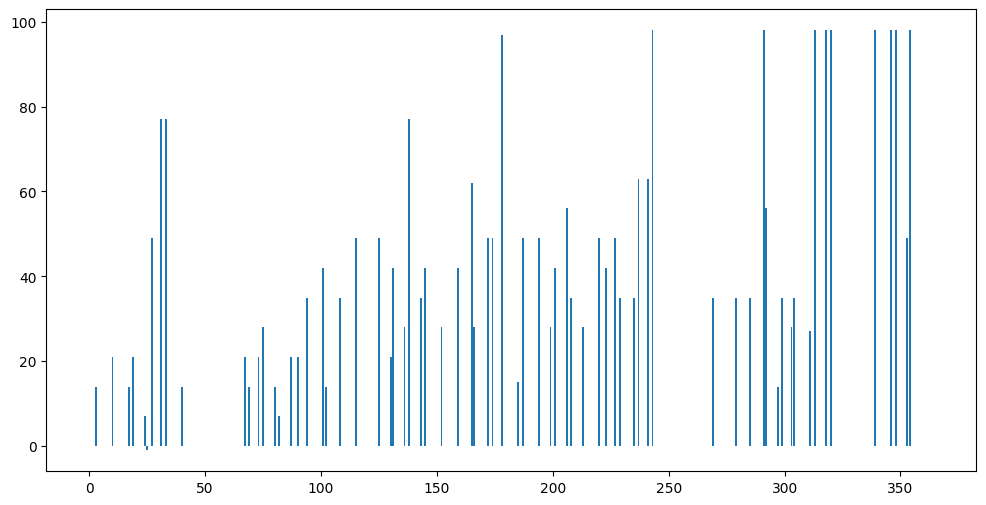

In [11]:
sum_df = full_df.sum().sort_values(ascending=True)

test_sample = full_df[sum_df.index[-450]].values
plt.figure(figsize=(12, 6))
plt.bar(range(len(full_df)), test_sample)


In [45]:
xd.T

transaction_date                         2022-01-01  2022-01-02  2022-01-03  \
internal_product_id internal_store_id                                         
1000423277513436210 1164003957453133052           0           0           0   
                    1870860275432322673           0           0           0   
                    2096630570628676364           0           0           0   
                    217259671743916895            0           0           0   
                    2787787091062505567           0           0           0   
...                                             ...         ...         ...   
999285078291803499  8814266804222259306           0           0           0   
                    9166806434271779264           0           0           0   
                    916729969482946290            0           0           0   
                    9191426288226387170           0           0           0   
                    949847633002469434            0           0           0   

transaction_date                         2022-01-04  2022-01-05  2022-01-06  \
internal_product_id internal_store_id                                         
1000423277513436210 1164003957453133052           0           0           0   
                    1870860275432322673           0           0           0   
                    2096630570628676364           0           0           0   
                    217259671743916895            0           0           0   
                    2787787091062505567           0           0           0   
...                                             ...         ...         ...   
999285078291803499  8814266804222259306           0           0           0   
                    9166806434271779264           0           0           0   
                    916729969482946290            0           0           0   
                    9191426288226387170           0           0           0   
                    949847633002469434            0           0           0   

transaction_date                         2022-01-07  2022-01-08  2022-01-09  \
internal_product_id internal_store_id                                         
1000423277513436210 1164003957453133052           0           0           0   
                    1870860275432322673           0           0           0   
                    2096630570628676364           0           0           0   
                    217259671743916895            0           0           0   
                    2787787091062505567           0           0           0   
...                                             ...         ...         ...   
999285078291803499  8814266804222259306           0           0           0   
                    9166806434271779264           0           0           0   
                    916729969482946290            0           0           0   
                    9191426288226387170           0           0           0   
                    949847633002469434            0           0           0   

transaction_date                         2022-01-10  ...  2022-12-22  \
internal_product_id internal_store_id                ...               
1000423277513436210 1164003957453133052           0  ...           0   
                    1870860275432322673           0  ...           0   
                    2096630570628676364           0  ...           0   
                    217259671743916895            0  ...           0   
                    2787787091062505567           0  ...           0   
...                                             ...  ...         ...   
999285078291803499  8814266804222259306           0  ...           0   
                    9166806434271779264           0  ...           0   
                    916729969482946290            0  ...           0   
                    9191426288226387170           0  ...           0   
                    949847633002469434            0 

<BarContainer object of 365 artists>

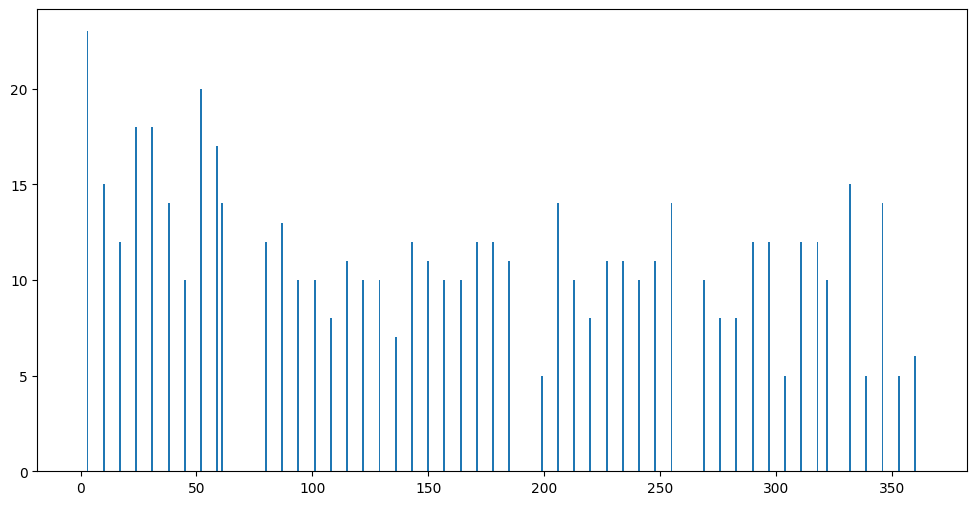

In [13]:
sum_df = xd.sum().sort_values(ascending=True)

test_sample = xd[sum_df.index[-450]].values
plt.figure(figsize=(12, 6))
plt.bar(range(len(xd)), test_sample)


# Transformando o Dataframe em um Dataset



In [14]:
# Admissão de um sample para teste univariado
sample = test_sample

# Criação de um feature básico, de diferença entre dados consecutivos 
feature_1 = [sample[t] - sample[t-1] for t in range(1, len(sample))]

# Normalização dos dados para a faixa [0, 1] - MÉTODO SIMPLES, PESQUISAR OUTROS
sample = (test_sample - np.min(test_sample)) / (np.max(test_sample) - np.min(test_sample))
feature_1 = (feature_1 - np.min(feature_1)) / (np.max(feature_1) - np.min(feature_1))



In [15]:
# Inicializando os vetores de entrada e os rótulos
X = []
y = []

# Número total de amostras (janelas diferentes) que podem ser extraídas
# de um mesmo sample
num_windows = len(sample) - input_size - output_size + 1
print(f"Número total de janelas extraídas: {num_windows}")
print(f"Para janelas de tamanho {input_size} e previsão de {output_size} dias à frente.")
# Extraindo janelas deslizantes
for i in range(num_windows):

    X_window = sample[i:i+input_size]             # janela de entrada
    feature_1_window = feature_1[i:i+input_size]      # janela de entrada

    X_window = np.stack([X_window,feature_1_window], axis=1)  # shape = (input_size, 4)

    y_window = sample[i+input_size:i+input_size+output_size]  # próximos dias da série

    X.append(X_window)
    y.append(y_window)

# Convertendo para arrays numpy e depois para tensores PyTorch
X = np.array(X)  # shape = [num_windows, input_size, num_features]
y = np.array(y)  # shape = [num_windows, output_size]
print()
print("O vetor de entrada  antes do flatten")
print(f"tem shape (num_windows, size_window, num_features): {X.shape}")

X = torch.tensor(X, dtype=torch.float32)  # shape = [n_samples, input_size, 1]

y = torch.tensor(y, dtype=torch.float32)  # shape = [n_samples, 1]


dataset_full = SingleSeriesDataset(X, y)


Número total de janelas extraídas: 329
Para janelas de tamanho 30 e previsão de 7 dias à frente.

O vetor de entrada  antes do flatten
tem shape (num_windows, size_window, num_features): (329, 30, 2)


# Separando os dados entre treino / validação

Os dados serão separados na proporção 80% - treino / 20% validação. Para séries temporais, é usual que essa separação seja feita de forma cronológica

In [16]:
# Ponto de separação entre treino e validação (Caso seja para envio, não há validação)
if split < 1:
    split_point = int(split * len(dataset_full))
    # Separação cronológica das janelas
    X_train, X_test = X[:split_point], X[split_point:]
    y_train, y_test = y[:split_point], y[split_point:]
else:
    X_train = X
    y_train = y

num_features = X_train.shape[2]

# Flatten do tensor para entrar na rede
X_train = X_train.view(X_train.shape[0], -1)  # shape = [num_windows_train, input_size * n_features]

if split < 1:
    X_test  = X_test.view(X_test.shape[0], -1) # shape = [num_windows_test, input_size * n_features]

print(f"Há um total de {len(dataset_full)} janelas e o split ocorre em {split*100:.0f}% do dataset")
print(f" O shape de X_train é {X_train.shape} e o shape de X_test é {X_test.shape}") if split < 1 else ""
print(f" O shape de y_train é {y_train.shape} e o shape de y_test é {y_test.shape}") if split < 1 else ""

Há um total de 329 janelas e o split ocorre em 80% do dataset
 O shape de X_train é torch.Size([263, 60]) e o shape de X_test é torch.Size([66, 60])
 O shape de y_train é torch.Size([263, 7]) e o shape de y_test é torch.Size([66, 7])


# Treinamento

In [31]:
# Adotando o dataset de treino
dataset = SingleSeriesDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size, shuffle=False) # shuffle=False para séries temporais

# Inicialização do modelo N-BEATS (considerando X_train com num_features)
model = NBeats(input_size * num_features, hidden_size, output_size, n_layers).to(device)

model, criterion, optimizer = train_model(model, learning_rate, epochs, device, dataloader)




Epoch 1/500, Loss: 1.3043
Epoch 2/500, Loss: 1.1084
Epoch 3/500, Loss: 1.0348
Epoch 4/500, Loss: 1.0020
Epoch 5/500, Loss: 0.9906
Epoch 6/500, Loss: 0.9886
Epoch 7/500, Loss: 0.9540
Epoch 8/500, Loss: 0.8992
Epoch 9/500, Loss: 0.8027
Epoch 10/500, Loss: 0.6865
Epoch 11/500, Loss: 0.5820
Epoch 12/500, Loss: 0.5155
Epoch 13/500, Loss: 0.4631
Epoch 14/500, Loss: 0.4345
Epoch 15/500, Loss: 0.4352
Epoch 16/500, Loss: 0.4271
Epoch 17/500, Loss: 0.4315
Epoch 18/500, Loss: 0.4195
Epoch 19/500, Loss: 0.3999
Epoch 20/500, Loss: 0.4018
Epoch 21/500, Loss: 0.4050
Epoch 22/500, Loss: 0.4008
Epoch 23/500, Loss: 0.3824
Epoch 24/500, Loss: 0.3963
Epoch 25/500, Loss: 0.3971
Epoch 26/500, Loss: 0.3760
Epoch 27/500, Loss: 0.3819
Epoch 28/500, Loss: 0.3816
Epoch 29/500, Loss: 0.3785
Epoch 30/500, Loss: 0.3668
Epoch 31/500, Loss: 0.3708
Epoch 32/500, Loss: 0.3785
Epoch 33/500, Loss: 0.3763
Epoch 34/500, Loss: 0.3690
Epoch 35/500, Loss: 0.3760
Epoch 36/500, Loss: 0.3676
Epoch 37/500, Loss: 0.3580
Epoch 38/5

In [32]:
device

device(type='cuda')

# Sanity check do modelo treinado

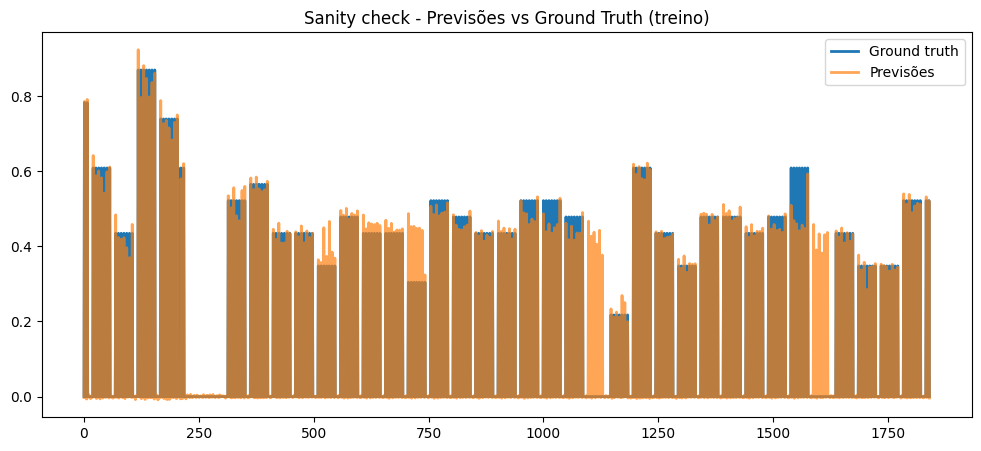

In [33]:
def sanity_check_plot(model, dataloader, device, output_size):
    """
    Plota previsões vs ground truth no período de treino
    """
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            preds = model(x)
            
            # Se seu modelo retorna (batch, output_size)
            preds = preds.cpu().numpy().flatten()
            y = y.cpu().numpy().flatten()

            all_preds.extend(preds)
            all_targets.extend(y)

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(all_targets, label="Ground truth", linewidth=2)
    plt.plot(all_preds, label="Previsões", linewidth=2, alpha=0.7)
    plt.title("Sanity check - Previsões vs Ground Truth (treino)")
    plt.legend()
    plt.show()

sanity_check_plot(model, dataloader, device, output_size)

In [20]:
y

tensor([[0.0000, 0.7826, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.7826, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.6087],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.2609, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2609,  ..., 0.0000, 0.0000, 0.0000]])

# Validação do modelo

São feitos dois testes:

- **Soft test:** Modelo  tenta fazer as previsões, mas não utiliza-as nas previsões futuras, utiliza sempre os *ground truth* como input
- **Hard test:** Modelo tenta fazer as previsões, e utiliza $y_{i-1}$ para a previsão de $y_i$

In [34]:
" Validando o modelo quando o split é menor que 1"
if split < 1:
    # Adotando o dataset de validação (soft)
    dataset = SingleSeriesDataset(X_test, y_test)
    dataloader = DataLoader(dataset, batch_size, shuffle=False) # shuffle=False para séries temporais

    all_preds_S, all_targets_S, avg_loss_test_S = soft_test(model, dataloader, device, criterion)

    # Validação hard - previsão cega das primeiras blind_horizon semanas
    all_preds_H, all_targets_H, avg_loss_test_H = hard_test(model, X_train, y_train, y_test, split_point, device, criterion, blind_horizon, output_size)

    " Sanity check da validação do modelo (preds and targets)"
    all_preds_array = []
    all_targets_array = []

    # Convert lists to tensors before flattening
    all_preds_tensor = torch.cat([t.unsqueeze(0) if t.dim() == 1 else t for t in all_preds_H], dim=0).flatten()
    all_targets_tensor = torch.cat([t.unsqueeze(0) if t.dim() == 1 else t for t in all_targets_H], dim=0).flatten()

    for t in all_preds_tensor:
        all_preds_array.append(t.detach().numpy())
    for t in all_targets_tensor:
        all_targets_array.append(t.detach().numpy())


    plt.figure(figsize=(12, 5))
    plt.plot(all_targets_array, label="Ground truth", linewidth=2)
    plt.plot(all_preds_array, label="Previsões", linewidth=2, alpha=0.7)
    plt.legend()


# Previsão cega (quando split == 1)

Previsão para envio para o hackathon das 4 primeiras semanas de janeiro/23. Utiliza todo o dataset como treino.

In [41]:
preds_blind = forecast_blind(model, X_train, blind_horizon, device, output_size) if split == 1.0 else print("Previsão cega não realizada, pois split < 1.0")
print(preds_blind)

preview_next_year = [i for i in preds_blind.detach().cpu().numpy()]
print(preview_next_year)

tensor([-3.4623e-04, -1.9967e-03,  1.2374e-03, -4.9249e-04,  4.4994e-04,
         5.2110e-01, -3.7198e-03, -1.4169e-02,  1.5698e-01, -5.4936e-02,
         2.1138e-01,  3.0359e-02,  6.7877e-01,  4.0440e-01, -7.3978e-03,
         6.4557e-03, -7.7656e-03, -2.0365e-03,  2.1047e-03,  1.7632e-01,
         6.7678e-02, -7.1942e-03,  1.1726e-01, -1.3489e-02,  4.0329e-01,
         3.6349e-02,  7.7491e-01,  3.7781e-01], grad_fn=<CatBackward0>)
[np.float32(-0.00034622848), np.float32(-0.0019966662), np.float32(0.0012374073), np.float32(-0.0004924927), np.float32(0.00044993684), np.float32(0.52110237), np.float32(-0.0037198253), np.float32(-0.014168521), np.float32(0.15697545), np.float32(-0.05493624), np.float32(0.211385), np.float32(0.03035862), np.float32(0.67876935), np.float32(0.40439895), np.float32(-0.0073978323), np.float32(0.0064557455), np.float32(-0.0077655613), np.float32(-0.0020364784), np.float32(0.0021046735), np.float32(0.17631602), np.float32(0.06767767), np.float32(-0.0071942247),

# Ponto de parada - RAB 18-09-25
- Temporais (mais fáceis de pensar e implementar)
- Categóricas (intrínsecas do produto ou da loja, como a categoria deles)
- De localização (apenas se der tempo)

Após termos feito isso, podemos então realizar normalização dos sinais, one hot encoding do que for viável e embedding de IDs etc